# Classiflow End-to-End Reproducible Notebook
## Dataset 1: Embryonal Methylation Multiclass (Sklearn Backend, Conservative Clinical Gate)

## 0. Title + Reviewer-Friendly Overview

Classiflow is a reproducible ML workflow framework for building and auditing classification models under explicit data-splitting and artifact-tracking constraints. It standardizes technical validation, independent testing, provenance capture, and promotion gate decisions so results can be reviewed and reproduced.

This notebook demonstrates the full local workflow for methylation-based CNS embryonal tumor multiclass classification using Classiflow project workflows. It executes technical validation (nested cross-validation), trains/finalizes a bundle, runs independent test inference, evaluates the Conservative Clinical Gate, and summarizes all critical artifacts.

Artifacts reviewed in this notebook:
- Technical validation run artifacts (nested CV): fold metrics, model selection outputs, resolved config, lineage, and reports.
- Independent test run artifacts: predictions, metrics, confusion matrix, inference plots, lineage, and reports.

Reproducibility notes:
- The notebook is local-only and uses no external services.
- Random seeds are fixed and shown.
- Dataset hashes, config, and lineage files are displayed.
- Headless-safe plotting is configured with `MPLBACKEND=Agg`.


## 1. Environment & Imports


In [1]:
import os
# os.environ.setdefault("MPLBACKEND", "Agg")  # headless-safe plotting backend

import json
import hashlib
import platform
import random
import shutil
import subprocess
import sys
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import yaml

from classiflow import __version__ as classiflow_version
from classiflow.projects.project_models import ProjectConfig, ThresholdsConfig

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print(f"Timestamp: {datetime.now().isoformat()}")
print(f"Python: {sys.version.split()[0]}")
print(f"Platform: {platform.platform()}")
print(f"Classiflow: {classiflow_version}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")

try:
    import sklearn
    print(f"scikit-learn: {sklearn.__version__}")
except Exception as exc:
    print(f"scikit-learn version unavailable: {exc}")

try:
    git_hash = subprocess.run(["git", "rev-parse", "HEAD"], capture_output=True, text=True, check=False).stdout.strip()
    print(f"Git commit: {git_hash if git_hash else 'unavailable'}")
except Exception:
    print("Git commit: unavailable")


Timestamp: 2026-02-09T13:18:09.160863
Python: 3.11.10
Platform: macOS-15.7.3-x86_64-i386-64bit
Classiflow: 0.1.0
NumPy: 1.26.4
Pandas: 2.2.3
Matplotlib: 3.9.2
scikit-learn: 1.5.2
Git commit: 813b91f311739b7591817da6b390d18ff53653c6


## 2. Load Data


In [2]:
TRAIN_CSV = Path("../data/embry_methyl_train_50.csv")
TEST_CSV = Path("../data/embry_methyl_test_50.csv")
LABEL_COL = "class"

for p in [TRAIN_CSV, TEST_CSV]:
    if not p.exists():
        raise FileNotFoundError(f"Required dataset not found: {p}")

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

for name, df in [("train", train_df), ("test", test_df)]:
    if LABEL_COL not in df.columns:
        raise ValueError(f"{name} missing required label column '{LABEL_COL}'")

feature_cols = [c for c in train_df.columns if c != LABEL_COL]
if not feature_cols:
    raise ValueError("No feature columns found after excluding label column")

print(f"Train shape: {train_df.shape}")
print(f"Test shape:  {test_df.shape}")
print(f"Feature columns: {len(feature_cols)}")

missing_summary = pd.DataFrame({
    "train_missing_pct": train_df.isna().mean().mul(100).round(3),
    "test_missing_pct": test_df.isna().mean().mul(100).round(3),
}).sort_values("train_missing_pct", ascending=False)

print("\nTop missingness rows:")
display(missing_summary.head(10))

leakage_tokens = ("label", "class", "target", "outcome", "y_")
suspicious = [
    c for c in train_df.columns
    if c != LABEL_COL and any(tok in c.lower() for tok in leakage_tokens)
]

assert not suspicious, (
    "Potential label leakage columns detected (heuristic). "
    f"Please review/remove before training: {suspicious}"
)
print("Label leakage heuristic check: PASS")


Train shape: (607, 51)
Test shape:  (151, 51)
Feature columns: 50

Top missingness rows:


,train_missing_pct,test_missing_pct
class,0.0,0.0
cg01323777,0.0,0.0
cg12386568,0.0,0.0
cg19027852,0.0,0.0
cg11948766,0.0,0.0
cg13254584,0.0,0.0
cg27632435,0.0,0.0
cg05347845,0.0,0.0
cg12392473,0.0,0.0
cg21472506,0.0,0.0


Label leakage heuristic check: PASS


## 3. Data Distributions (Reviewer-Facing)


In [3]:
def class_count_table(train_df: pd.DataFrame, test_df: pd.DataFrame, label_col: str) -> pd.DataFrame:
    tr = train_df[label_col].value_counts().rename("train_count")
    te = test_df[label_col].value_counts().rename("test_count")
    out = pd.concat([tr, te], axis=1).fillna(0).astype(int)
    out["train_pct"] = (out["train_count"] / out["train_count"].sum() * 100).round(2)
    out["test_pct"] = (out["test_count"] / out["test_count"].sum() * 100).round(2)
    return out.sort_index()

strat_table = class_count_table(train_df, test_df, LABEL_COL)
display(strat_table)

fig, axes = plt.subplots(1, 2, figsize=(14, 4), constrained_layout=True)
strat_table["train_count"].plot(kind="bar", ax=axes[0])
axes[0].set_title("Train Class Counts")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=75)

strat_table["test_count"].plot(kind="bar", ax=axes[1])
axes[1].set_title("Test Class Counts")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis="x", rotation=75)
plt.show()

x = np.arange(len(strat_table.index))
width = 0.4
fig, ax = plt.subplots(figsize=(14, 4), constrained_layout=True)
ax.bar(x - width / 2, strat_table["train_pct"], width=width, label="Train")
ax.bar(x + width / 2, strat_table["test_pct"], width=width, label="Test")
ax.set_xticks(x)
ax.set_xticklabels(strat_table.index, rotation=75)
ax.set_ylabel("Percent")
ax.set_title("Class Proportions: Train vs Test")
ax.legend()
plt.show()


,train_count,test_count,train_pct,test_pct
class,,,,
ATRT_MYC,29,2,4.78,1.32
ATRT_SHH,46,5,7.58,3.31
ATRT_TYR,37,2,6.10,1.32
CNS_BCOR_ITD,23,3,3.79,1.99
CNS_NB_FOXR2,39,4,6.43,2.65
ETMR_C19MC,43,6,7.08,3.97
MB_G3,77,22,12.69,14.57
MB_G4,138,43,22.73,28.48
MB_SHH_CHL_AD,84,42,13.84,27.81


/var/folders/qw/wt3crg911d32djy9xk8j0q8r0000gn/T/ipykernel_4555/1616894314.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/var/folders/qw/wt3crg911d32djy9xk8j0q8r0000gn/T/ipykernel_4555/1616894314.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


## 4. Create / Display Project Configuration


In [4]:
# Fast mode toggle for reviewer runtime practicality.
FAST_MODE = True

if FAST_MODE:
    outer_folds = 3
    inner_folds = 3
    repeats = 1
    candidates = ["logistic_regression", "random_forest", "gradient_boost"]
else:
    # You can raise fold counts or add candidates here for manuscript-scale runs.
    outer_folds = 5
    inner_folds = 5
    repeats = 2
    candidates = ["logistic_regression", "svm", "random_forest", "gradient_boost"]

OUTPUT_ROOT = Path("runs/embry_methyl_multiclass_sklearn")
PROJECT_DIR = OUTPUT_ROOT / "project"
PROJECT_DIR.mkdir(parents=True, exist_ok=True)
(PROJECT_DIR / "registry").mkdir(parents=True, exist_ok=True)
(PROJECT_DIR / "data" / "train").mkdir(parents=True, exist_ok=True)
(PROJECT_DIR / "data" / "test").mkdir(parents=True, exist_ok=True)
(PROJECT_DIR / "runs").mkdir(parents=True, exist_ok=True)
(PROJECT_DIR / "promotion").mkdir(parents=True, exist_ok=True)

project_yaml = PROJECT_DIR / "project.yaml"
thresholds_yaml = PROJECT_DIR / "registry" / "thresholds.yaml"
labels_yaml = PROJECT_DIR / "registry" / "labels.yaml"
features_yaml = PROJECT_DIR / "registry" / "features.yaml"

project_payload = {
    "project": {
        "id": "EMBRY_METHYL_MC",
        "name": "Embryonal Methylation Multiclass",
        "description": "Reviewer notebook reproducible run",
        "owner": "local",
    },
    "data": {
        "train": {"manifest": str(TRAIN_CSV.resolve())},
        "test": {"manifest": str(TEST_CSV.resolve())},
    },
    "key_columns": {
        "sample_id": None,
        "patient_id": None,
        "label": LABEL_COL,
        "slide_id": None,
        "specimen_id": None,
    },
    "task": {
        "mode": "multiclass",
        "patient_stratified": False,
        "hierarchy_path": None,
    },
    "validation": {
        "nested_cv": {
            "outer_folds": outer_folds,
            "inner_folds": inner_folds,
            "repeats": repeats,
            "seed": SEED,
        }
    },
    "models": {
        "candidates": candidates,
        "selection_metric": "f1",
        "selection_direction": "max",
    },
    "imbalance": {
        "smote": {
            "enabled": False,
            "compare": False,
        }
    },
    "multiclass": {
        "group_stratify": False,
        "backend": "sklearn_cpu",
        "sklearn": {
            "logreg": {
                "solver": "saga",
                "multi_class": "auto",
                "penalty": "l2",
                "max_iter": 5000,
                "tol": 1e-3,
                "C": 1.0,
                "class_weight": "balanced",
                "n_jobs": -1,
            }
        },
    },
    "metrics": {
        "primary": ["f1", "balanced_accuracy"],
        "averaging": "macro",
        "include_confidence_intervals": False,
    },
    "calibration": {
        "calibrate_meta": True,
        "method": "sigmoid",
        "cv": 3,
        "bins": 10,
        "isotonic_min_samples": 100,
    },
    "final_model": {
        "sampler": "none",
        "sanity_min_std": 0.02,
        "sanity_max_mean_deviation": 0.15,
        "train_from_scratch": True,
        "verify_dataset_hash": True,
    },
    "bundle": {
        "name": "model_bundle",
        "include_preprocessing": True,
        "format": "zip",
    },
    "execution": {
        "engine": "sklearn",
    },
}

thresholds_payload = {
    "promotion_gate_template": "clinical_conservative",
    "technical_validation": {"required": {}, "safety": {}, "stability": None},
    "independent_test": {"required": {}, "safety": {}, "stability": None},
    "promotion": {"calibration": {"brier_max": None, "ece_max": None}},
}

validated_config = ProjectConfig.model_validate(project_payload)
validated_config.save(project_yaml)
ThresholdsConfig.model_validate(thresholds_payload).save(thresholds_yaml)

labels_yaml.write_text("labels: {}", encoding="utf-8")
features_yaml.write_text("features: {}", encoding="utf-8")

print("Project config written:", project_yaml)
print("Threshold config written:", thresholds_yaml)
print("\nRequested configuration (YAML):")
print(yaml.safe_dump(project_payload, sort_keys=False))


Project config written: runs/embry_methyl_multiclass_sklearn/project/project.yaml
Threshold config written: runs/embry_methyl_multiclass_sklearn/project/registry/thresholds.yaml

Requested configuration (YAML):
project:
  id: EMBRY_METHYL_MC
  name: Embryonal Methylation Multiclass
  description: Reviewer notebook reproducible run
  owner: local
data:
  train:
    manifest: /Users/alex/Documents/project-MLSubtype/data/embry_methyl_train_50.csv
  test:
    manifest: /Users/alex/Documents/project-MLSubtype/data/embry_methyl_test_50.csv
key_columns:
  sample_id: null
  patient_id: null
  label: class
  slide_id: null
  specimen_id: null
task:
  mode: multiclass
  patient_stratified: false
  hierarchy_path: null
validation:
  nested_cv:
    outer_folds: 3
    inner_folds: 3
    repeats: 1
    seed: 42
models:
  candidates:
  - logistic_regression
  - random_forest
  - gradient_boost
  selection_metric: f1
  selection_direction: max
imbalance:
  smote:
    enabled: false
    compare: false


In [5]:
print("Resolved/effective config from validation model:")
resolved_cfg = ProjectConfig.load(project_yaml)
print(yaml.safe_dump(resolved_cfg.to_yaml_dict(), sort_keys=False))


Resolved/effective config from validation model:
project:
  id: EMBRY_METHYL_MC
  name: Embryonal Methylation Multiclass
  description: Reviewer notebook reproducible run
  owner: local
data:
  train:
    manifest: /Users/alex/Documents/project-MLSubtype/data/embry_methyl_train_50.csv
  test:
    manifest: /Users/alex/Documents/project-MLSubtype/data/embry_methyl_test_50.csv
key_columns:
  label: class
task:
  mode: multiclass
  patient_stratified: false
validation:
  nested_cv:
    outer_folds: 3
    inner_folds: 3
    repeats: 1
    seed: 42
models:
  candidates:
  - logistic_regression
  - random_forest
  - gradient_boost
  selection_metric: f1
  selection_direction: max
imbalance:
  smote:
    enabled: false
    compare: false
multiclass:
  group_stratify: false
  backend: sklearn_cpu
  sklearn:
    logreg:
      solver: saga
      multi_class: auto
      penalty: l2
      max_iter: 5000
      tol: 0.001
      C: 1.0
      class_weight: balanced
      n_jobs: -1
metrics:
  primary:

## 5. Run 1 — Technical Validation (Nested CV)


In [6]:
def run_cmd(cmd, cwd=None):
    print("$", " ".join(cmd))
    out = subprocess.run(cmd, cwd=cwd, capture_output=True, text=True)
    if out.stdout:
        print(out.stdout)
    if out.returncode != 0:
        if out.stderr:
            print(out.stderr)
        raise RuntimeError(f"Command failed ({out.returncode}): {' '.join(cmd)}")
    return out

def file_sha256(path: Path) -> str:
    h = hashlib.sha256()
    with path.open("rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()

print("Dataset hashes:")
print("train:", file_sha256(TRAIN_CSV))
print("test: ", file_sha256(TEST_CSV))

run_cmd(["classiflow", "project", "register-dataset", str(PROJECT_DIR), "--type", "train", "--manifest", str(TRAIN_CSV)])
run_cmd(["classiflow", "project", "register-dataset", str(PROJECT_DIR), "--type", "test", "--manifest", str(TEST_CSV)])

run_cmd(["classiflow", "project", "run-technical", str(PROJECT_DIR), "--run-id", "technical"])

TECHNICAL_RUN = PROJECT_DIR / "runs" / "technical_validation" / "technical"
if not TECHNICAL_RUN.exists():
    raise FileNotFoundError(f"Technical run directory not found: {TECHNICAL_RUN}")

TECHNICAL_ALIAS = OUTPUT_ROOT / "technical"
if TECHNICAL_ALIAS.exists() and TECHNICAL_ALIAS.is_dir():
    shutil.rmtree(TECHNICAL_ALIAS)
shutil.copytree(TECHNICAL_RUN, TECHNICAL_ALIAS)
print("Technical artifacts mirrored to:", TECHNICAL_ALIAS)


Dataset hashes:
train: dbc1799b3e2430c5f6e8c2e88037d853e5dc6fbae2c7f924f8e67c450bf7a47e
test:  38beac68b1760227319720c58271b74dad96ec89aef550c5ae1d3062f07ed8bd
$ classiflow project register-dataset runs/embry_methyl_multiclass_sklearn/project --type train --manifest ../data/embry_methyl_train_50.csv
Registered train dataset: dbc1799b3e24...

$ classiflow project register-dataset runs/embry_methyl_multiclass_sklearn/project --type test --manifest ../data/embry_methyl_test_50.csv
Registered test dataset: 38beac68b176...

$ classiflow project run-technical runs/embry_methyl_multiclass_sklearn/project --run-id technical
runs/embry_methyl_multiclass_sklearn/project/runs/technical_validation/technical

Technical artifacts mirrored to: runs/embry_methyl_multiclass_sklearn/technical


In [11]:
def require_file(path: Path, context: str):
    if not path.exists():
        raise FileNotFoundError(f"{context}: expected file not found -> {path}")
    return path

def find_latest_run_dir(base_dir: Path) -> Path:
    if not base_dir.exists():
        raise FileNotFoundError(f"Run base directory missing: {base_dir}")
    candidates = [p for p in base_dir.iterdir() if p.is_dir()]
    if not candidates:
        raise FileNotFoundError(f"No run directories found under: {base_dir}")
    return sorted(candidates, key=lambda p: p.stat().st_mtime)[-1]

def load_metrics(run_dir: Path):
    summary_json = run_dir / "metrics_summary.json"
    metrics_json = run_dir / "metrics.json"
    if summary_json.exists():
        return json.loads(summary_json.read_text(encoding="utf-8"))
    if metrics_json.exists():
        return json.loads(metrics_json.read_text(encoding="utf-8"))
    alt_csv = run_dir / "metrics_outer_multiclass_eval.csv"
    if alt_csv.exists():
        df = pd.read_csv(alt_csv)
        return {"fallback_csv": True, "table": df}
    raise FileNotFoundError(f"No metrics artifact found in {run_dir}")

def load_predictions(run_dir: Path):
    pred_path = run_dir / "predictions.csv"
    if pred_path.exists():
        return pd.read_csv(pred_path)
    return None

def load_config(run_dir: Path):
    resolved = run_dir / "config.resolved.yaml"
    if resolved.exists():
        return yaml.safe_load(resolved.read_text(encoding="utf-8"))
    run_manifest = run_dir / "run.json"
    if run_manifest.exists():
        return json.loads(run_manifest.read_text(encoding="utf-8"))
    raise FileNotFoundError(f"No resolved config/run manifest found in {run_dir}")

def load_gate_results(project_dir: Path):
    gate_json = project_dir / "promotion" / "promotion_decision.json"
    gate_yaml = project_dir / "promotion" / "decision.yaml"
    if gate_json.exists():
        return json.loads(gate_json.read_text(encoding="utf-8"))
    if gate_yaml.exists():
        return yaml.safe_load(gate_yaml.read_text(encoding="utf-8"))
    raise FileNotFoundError(
        "Promotion results missing. Expected one of: "
        f"{gate_json} or {gate_yaml}. Run recommendation step first."
    )

tech_metrics = load_metrics(TECHNICAL_ALIAS)
outer_metrics_csv = require_file(TECHNICAL_ALIAS / "metrics_outer_multiclass_eval.csv", "Technical metrics")
inner_results_csv = require_file(TECHNICAL_ALIAS / "inner_cv_results.csv", "Inner CV selection summary")

outer_df = pd.read_csv(outer_metrics_csv)
outer_val = outer_df[outer_df.get("phase", "val") == "val"].copy()
inner_df = pd.read_csv(inner_results_csv)

print("Technical metrics summary:")
if isinstance(tech_metrics, dict) and "summary" in tech_metrics:
    display(pd.DataFrame([tech_metrics["summary"]]))
else:
    print("metrics_summary.json unavailable; showing fallback table head")
    display(outer_val.head())

print("Inner selection summary (top rows):")
selection_cols = [c for c in ["fold", "model_name", "sampler", "mean_test_f1_macro", "mean_test_score", "rank_test_f1_macro"] if c in inner_df.columns]
display(inner_df[selection_cols].sort_values(selection_cols[0] if selection_cols else inner_df.columns[0]).head(20))


Technical metrics summary:


,f1_macro,balanced_accuracy,recall,specificity,ppv,npv,precision,mcc
0,0.954026,0.95245,0.95245,0.995286,0.959763,0.995401,0.959763,0.949211


Inner selection summary (top rows):


,fold,model_name,sampler,mean_test_f1_macro,rank_test_f1_macro
0,1,LogisticRegression,none,0.959811,4
21,1,GradientBoosting,none,0.708629,5
20,1,GradientBoosting,none,0.706212,6
19,1,GradientBoosting,none,0.894374,1
18,1,GradientBoosting,none,0.881920,2
17,1,GradientBoosting,none,0.687570,8
15,1,GradientBoosting,none,0.763570,3
14,1,GradientBoosting,none,0.748026,4
13,1,RandomForest,none,0.968407,4
12,1,RandomForest,none,0.973396,1


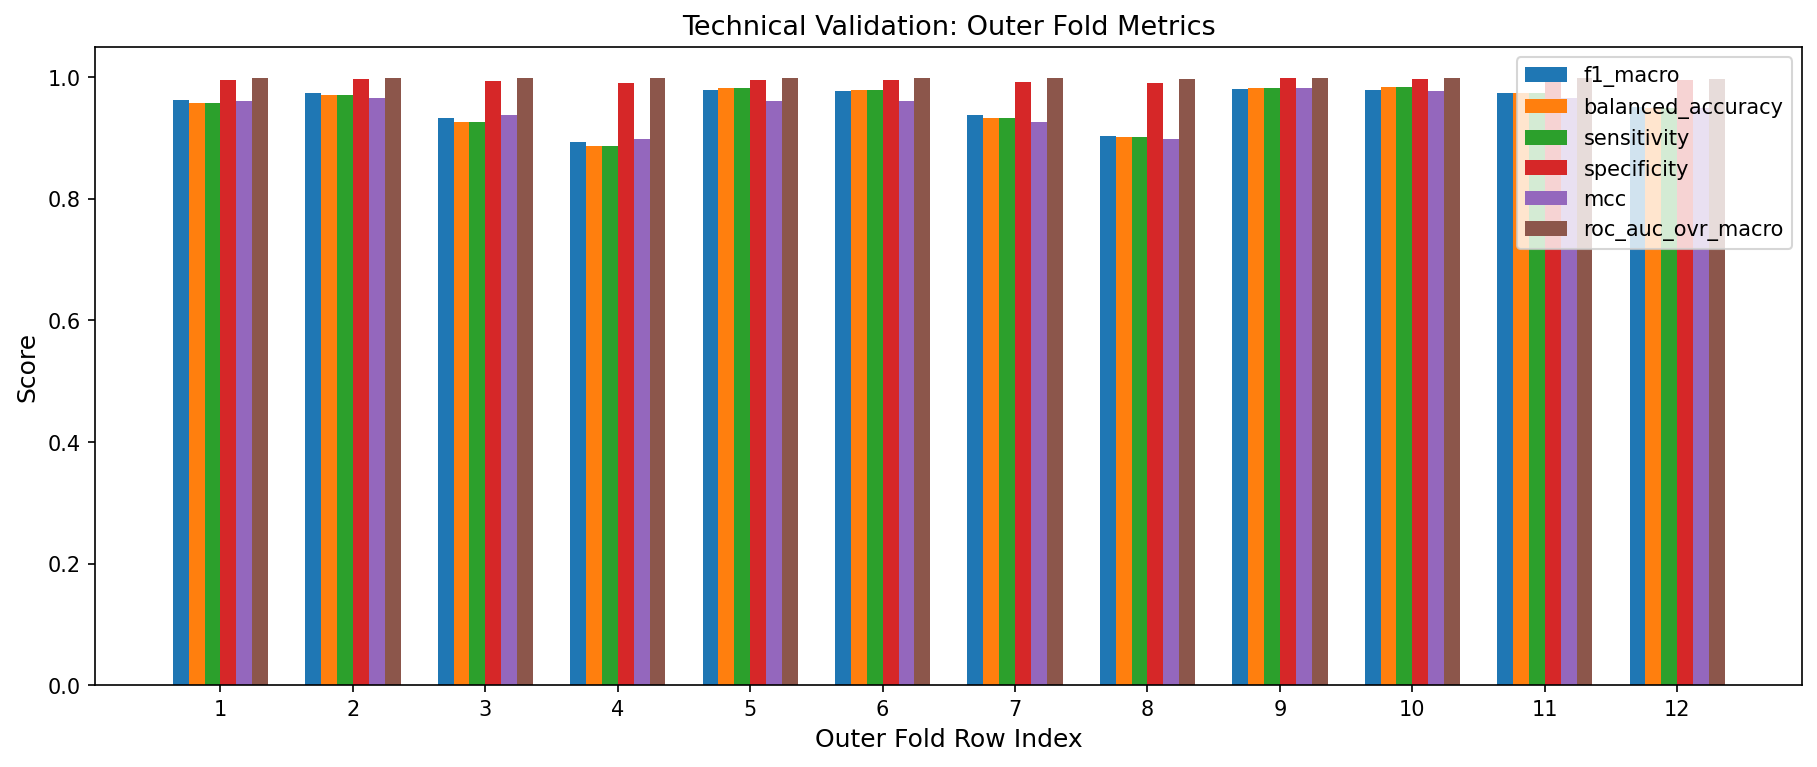

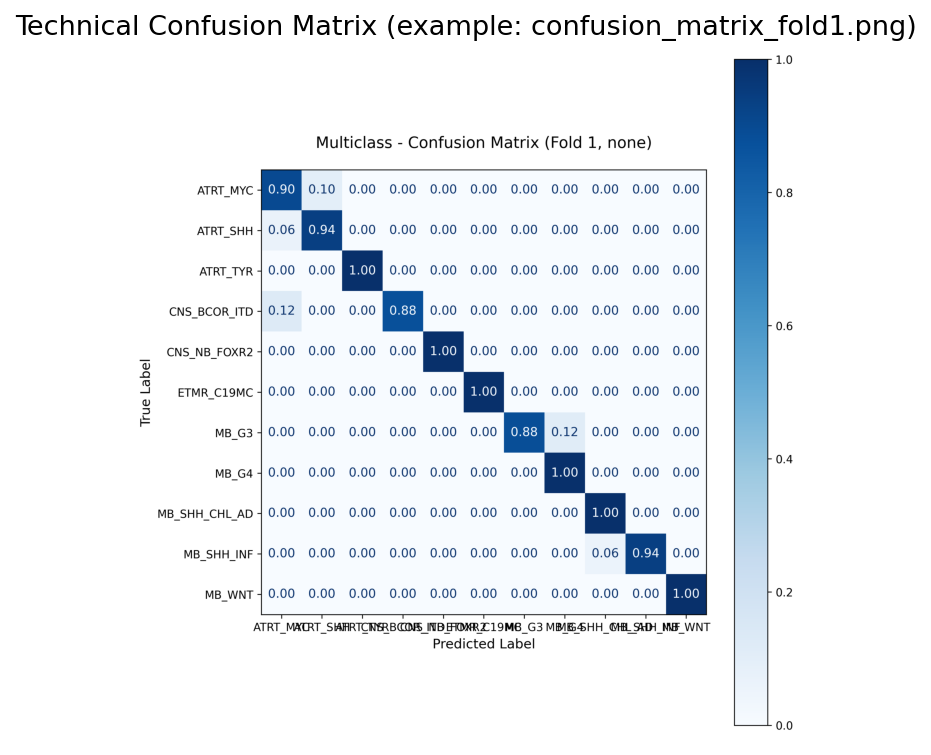

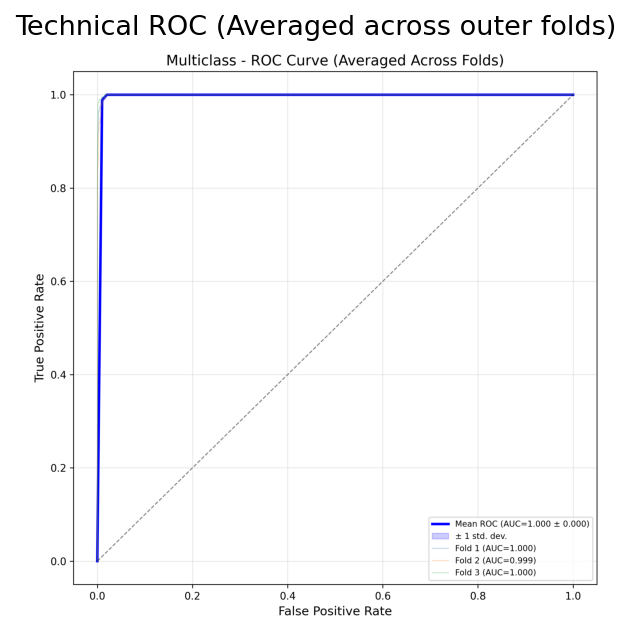

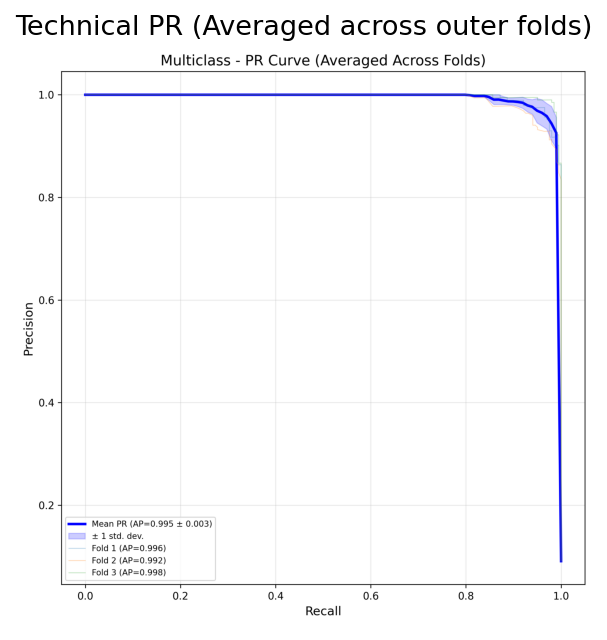

In [12]:
key_metrics = ["f1_macro", "balanced_accuracy", "sensitivity", "specificity", "mcc", "roc_auc_ovr_macro"]
present = [m for m in key_metrics if m in outer_val.columns]

if not present:
    print("No expected outer-fold key metrics found for plotting.")
else:
    fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)
    x = np.arange(len(outer_val))
    width = 0.12 if len(present) >= 5 else 0.18
    for i, m in enumerate(present):
        ax.bar(x + i * width, outer_val[m].astype(float), width=width, label=m)
    ax.set_title("Technical Validation: Outer Fold Metrics")
    ax.set_xlabel("Outer Fold Row Index")
    ax.set_ylabel("Score")
    ax.set_xticks(x + width * (len(present) - 1) / 2)
    ax.set_xticklabels([str(i + 1) for i in range(len(outer_val))])
    ax.set_ylim(0, 1.05)
    ax.legend()
    plt.show()

cm_pngs = sorted(TECHNICAL_ALIAS.glob("fold*/multiclass_*/confusion_matrix_fold*.png"))
if cm_pngs:
    img = plt.imread(cm_pngs[0])
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Technical Confusion Matrix (example: {cm_pngs[0].name})")
    plt.show()
else:
    print("Technical confusion matrix image not found; no stored predictions available to recompute aggregate confusion matrix.")

roc_png = TECHNICAL_ALIAS / "averaged_roc.png"
if roc_png.exists():
    img = plt.imread(roc_png)
    plt.figure(figsize=(6, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Technical ROC (Averaged across outer folds)")
    plt.show()
else:
    print("Averaged ROC plot not found in technical artifacts.")

pr_png = TECHNICAL_ALIAS / "averaged_pr.png"
if pr_png.exists():
    img = plt.imread(pr_png)
    plt.figure(figsize=(6, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Technical PR (Averaged across outer folds)")
    plt.show()
else:
    print("PR curve plot unavailable in technical artifacts; omitted.")


## 6. Promotion Gate Evaluation — Technical

**Conservative Clinical Gate (layman explanation):**
The model should be consistently accurate, should not miss too many true cases, and should show strong overall agreement with truth beyond chance.


In [14]:
# Build final bundle (still fine here)
run_cmd([
    "classiflow", "project", "build-bundle",
    str(PROJECT_DIR),
    "--technical-run", "technical",
    "--run-id", "final"
])

# Technical-only gate evaluation (no recommend yet)
from classiflow.projects.promotion_templates import get_promotion_gate_template
from classiflow.projects.promotion import resolve_metric

template = get_promotion_gate_template("clinical_conservative")
print("Gate template:", template.display_name)
print("Layman explanation:", template.layman_explanation)

# Load technical metrics summary
tech_metrics_payload = load_metrics(TECHNICAL_ALIAS)
tech_summary = dict(tech_metrics_payload.get("summary", {}))

# Fallback: fill missing metrics from outer CV table means
outer_csv = TECHNICAL_ALIAS / "metrics_outer_multiclass_eval.csv"
if outer_csv.exists():
    outer_df = pd.read_csv(outer_csv)
    outer_val = outer_df[outer_df.get("phase", "val") == "val"].copy()
    for col in ["recall", "sensitivity", "mcc", "balanced_accuracy", "f1_macro", "f1_weighted"]:
        if col in outer_val.columns and col not in tech_summary:
            tech_summary[col] = float(pd.to_numeric(outer_val[col], errors="coerce").mean())

rows = []
for gate in template.gates:
    observed = resolve_metric(tech_summary, gate.metric)
    passed = (observed is not None) and (
        observed >= gate.threshold if gate.op == ">=" else
        observed > gate.threshold if gate.op == ">" else
        observed <= gate.threshold if gate.op == "<=" else
        observed < gate.threshold
    )
    rows.append({
        "metric": gate.metric,
        "op": gate.op,
        "threshold": gate.threshold,
        "observed": None if observed is None else float(observed),
        "passed": bool(passed),
    })

gate_table = pd.DataFrame(rows)
display(gate_table)
print("Technical overall pass:", bool(gate_table["passed"].all()))


$ classiflow project build-bundle runs/embry_methyl_multiclass_sklearn/project --technical-run technical --run-id final
runs/embry_methyl_multiclass_sklearn/project/runs/final_model/final

Gate template: Conservative Clinical Gate
Layman explanation: The model is consistently right across different groups and doesn't miss too many real cases or overcall too often.


,metric,op,threshold,observed,passed
0,Balanced Accuracy,>=,0.80,0.952450,True
1,Sensitivity,>=,0.85,0.952450,True
2,MCC,>=,0.60,0.949211,True


Technical overall pass: True


## 7. Run 2 — Independent Test Evaluation


In [15]:
run_cmd(["classiflow", "project", "run-test", str(PROJECT_DIR), "--final-run", "final", "--run-id", "independent"])

INDEPENDENT_RUN = PROJECT_DIR / "runs" / "independent_test" / "independent"
if not INDEPENDENT_RUN.exists():
    raise FileNotFoundError(f"Independent run directory not found: {INDEPENDENT_RUN}")

INDEPENDENT_ALIAS = OUTPUT_ROOT / "independent"
if INDEPENDENT_ALIAS.exists() and INDEPENDENT_ALIAS.is_dir():
    shutil.rmtree(INDEPENDENT_ALIAS)
shutil.copytree(INDEPENDENT_RUN, INDEPENDENT_ALIAS)
print("Independent artifacts mirrored to:", INDEPENDENT_ALIAS)

run_cmd([
    "classiflow", "project", "recommend", str(PROJECT_DIR),
    "--technical-run", "technical",
    "--test-run", "independent",
    "--promotion-gate-template", "clinical_conservative",
])


$ classiflow project run-test runs/embry_methyl_multiclass_sklearn/project --final-run final --run-id independent
runs/embry_methyl_multiclass_sklearn/project/runs/independent_test/independent

Independent artifacts mirrored to: runs/embry_methyl_multiclass_sklearn/independent
$ classiflow project recommend runs/embry_methyl_multiclass_sklearn/project --technical-run technical --test-run independent --promotion-gate-template clinical_conservative
runs/embry_methyl_multiclass_sklearn/project/promotion/promotion_report.md



CompletedProcess(args=['classiflow', 'project', 'recommend', 'runs/embry_methyl_multiclass_sklearn/project', '--technical-run', 'technical', '--test-run', 'independent', '--promotion-gate-template', 'clinical_conservative'], returncode=0, stdout='runs/embry_methyl_multiclass_sklearn/project/promotion/promotion_report.md\n', stderr='')

Independent test overall metrics:


,n_samples,accuracy,balanced_accuracy,f1_macro,f1_weighted,f1_micro,mcc,sensitivity,specificity,ppv,npv,recall,precision,log_loss,brier,brier_calibrated,log_loss_calibrated,ece,ece_calibrated,calibration_bins
0,151,0.89404,0.896039,0.840262,0.894915,0.89404,0.870129,0.896039,0.988799,0.842752,0.988201,0.896039,0.842752,0.299076,0.14156,0.14156,0.299076,0.04327,0.04327,10


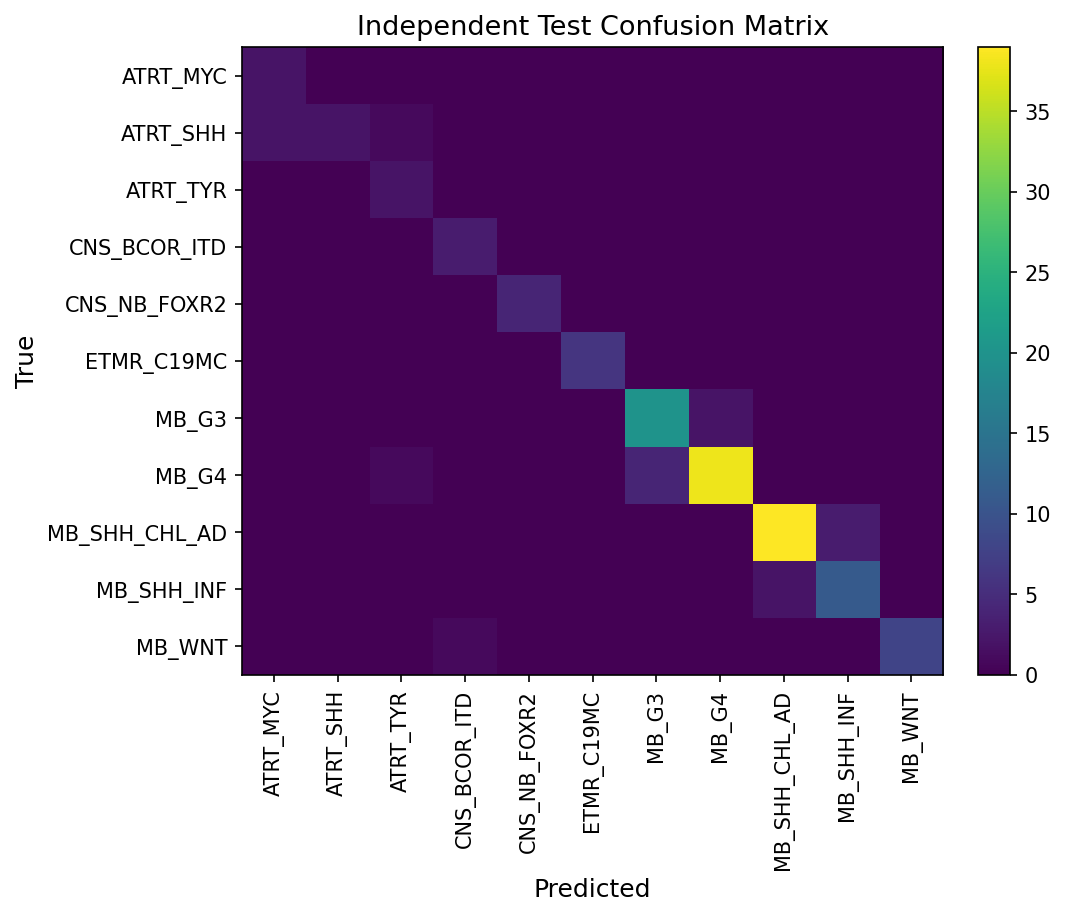

Calibration curve file found but expected columns missing.


,class,precision,recall,f1,support
0,ATRT_MYC,0.500000,1.000000,0.666667,2
1,ATRT_SHH,1.000000,0.400000,0.571429,5
2,ATRT_TYR,0.500000,1.000000,0.666667,2
3,CNS_BCOR_ITD,0.750000,1.000000,0.857143,3
4,CNS_NB_FOXR2,1.000000,1.000000,1.000000,4
5,ETMR_C19MC,1.000000,1.000000,1.000000,6
6,MB_G3,0.833333,0.909091,0.869565,22
7,MB_G4,0.950000,0.883721,0.915663,43
8,MB_SHH_CHL_AD,0.951220,0.928571,0.939759,42
9,MB_SHH_INF,0.785714,0.846154,0.814815,13


In [16]:
ind_metrics_payload = load_metrics(INDEPENDENT_ALIAS)
if "overall" not in ind_metrics_payload:
    raise ValueError("Independent metrics did not include 'overall' block")

overall = ind_metrics_payload["overall"]
overall_numeric = {k: v for k, v in overall.items() if isinstance(v, (int, float, bool))}
print("Independent test overall metrics:")
display(pd.DataFrame([overall_numeric]))

cm = overall.get("confusion_matrix", {})
labels = cm.get("labels")
matrix = cm.get("matrix")
if labels is not None and matrix is not None:
    cm_arr = np.array(matrix)
    fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)
    im = ax.imshow(cm_arr, aspect="auto")
    ax.set_title("Independent Test Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    plt.colorbar(im, ax=ax)
    plt.show()
else:
    print("Confusion matrix not available in metrics.json")

cal_curve = INDEPENDENT_ALIAS / "calibration_curve.csv"
if cal_curve.exists():
    cal_df = pd.read_csv(cal_curve)
    needed = {"mean_predicted_proba", "observed_frequency"}
    if needed.issubset(cal_df.columns):
        fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
        ax.plot(cal_df["mean_predicted_proba"], cal_df["observed_frequency"], marker="o", label="Model")
        ax.plot([0, 1], [0, 1], linestyle="--", label="Ideal")
        ax.set_title("Calibration Curve")
        ax.set_xlabel("Mean Predicted Probability")
        ax.set_ylabel("Observed Frequency")
        ax.legend()
        plt.show()
    else:
        print("Calibration curve file found but expected columns missing.")
else:
    print("Calibration curve unavailable for this run; skipped.")

per_class = overall.get("per_class")
if per_class:
    per_class_df = pd.DataFrame(per_class)
    display(per_class_df)
else:
    print("Per-class metrics not available in metrics payload.")


## 8. Promotion Gate Evaluation — Independent


In [18]:
from pathlib import Path
import json
import pandas as pd
from classiflow.projects.promotion_templates import get_promotion_gate_template
from classiflow.projects.promotion import resolve_metric

# 1) Ensure recommend has BOTH technical + independent runs (required for detailed per-phase gates)
run_cmd([
    "classiflow", "project", "recommend", str(PROJECT_DIR),
    "--technical-run", "technical",
    "--test-run", "independent",
    "--promotion-gate-template", "clinical_conservative",
])

# 2) Prefer rich JSON payload
promo_json = PROJECT_DIR / "promotion" / "promotion_decision.json"
promo_yaml = PROJECT_DIR / "promotion" / "decision.yaml"

if promo_json.exists():
    gate_payload = json.loads(promo_json.read_text(encoding="utf-8"))
    print("Loaded:", promo_json)
elif promo_yaml.exists():
    import yaml
    gate_payload = yaml.safe_load(promo_yaml.read_text(encoding="utf-8"))
    print("Loaded:", promo_yaml, "(summary-only payload)")
else:
    raise FileNotFoundError("No promotion payload found in project/promotion/")

phase_results = gate_payload.get("phase_results", {}) if isinstance(gate_payload, dict) else {}
ind_gate = phase_results.get("independent_test") or {}
tech_gate = phase_results.get("technical_validation") or {}

ind_per_gate = ind_gate.get("per_gate_results", [])

# 3) If missing per_gate_results, compute independent gate table directly from metrics + template
if not ind_per_gate:
    print("No per_gate_results in payload; computing gate details from independent metrics.")
    ind_metrics = load_metrics(INDEPENDENT_ALIAS).get("overall", {})
    template = get_promotion_gate_template("clinical_conservative")

    rows = []
    for g in template.gates:
        observed = resolve_metric(ind_metrics, g.metric)
        passed = (observed is not None) and (
            observed >= g.threshold if g.op == ">=" else
            observed > g.threshold if g.op == ">" else
            observed <= g.threshold if g.op == "<=" else
            observed < g.threshold
        )
        rows.append({
            "metric": g.metric,
            "op": g.op,
            "threshold": g.threshold,
            "observed_value": None if observed is None else float(observed),
            "passed": bool(passed),
            "aggregation": "mean",
        })
    ind_gate_table = pd.DataFrame(rows)
else:
    ind_gate_table = pd.DataFrame(ind_per_gate)
    keep = [c for c in ["metric", "op", "threshold", "observed_value", "passed", "aggregation"] if c in ind_gate_table.columns]
    ind_gate_table = ind_gate_table[keep]

display(ind_gate_table)

ind_overall = ind_gate.get("passed")
if ind_overall is None:
    ind_overall = bool(ind_gate_table["passed"].all()) if "passed" in ind_gate_table.columns else gate_payload.get("decision", "unknown")

print("Independent overall pass:", ind_overall)

if bool(tech_gate.get("passed")) and (not bool(ind_overall)):
    print("Interpretation: Technical validation passed but independent test failed; this suggests reduced generalization on unseen data.")


$ classiflow project recommend runs/embry_methyl_multiclass_sklearn/project --technical-run technical --test-run independent --promotion-gate-template clinical_conservative
runs/embry_methyl_multiclass_sklearn/project/promotion/promotion_report.md

Loaded: runs/embry_methyl_multiclass_sklearn/project/promotion/promotion_decision.json
No per_gate_results in payload; computing gate details from independent metrics.


,metric,op,threshold,observed_value,passed,aggregation
0,Balanced Accuracy,>=,0.80,0.896039,True,mean
1,Sensitivity,>=,0.85,0.896039,True,mean
2,MCC,>=,0.60,0.870129,True,mean


Independent overall pass: True


## 9. Artifact Review / Provenance


In [19]:
def summarize_loaded(path: Path):
    try:
        if path.suffix in {".json", ".yaml", ".yml"}:
            text = path.read_text(encoding="utf-8")
            data = json.loads(text) if path.suffix == ".json" else yaml.safe_load(text)
            if isinstance(data, dict):
                return ", ".join(list(data.keys())[:8])
            return f"type={type(data).__name__}"
        if path.suffix == ".csv":
            df = pd.read_csv(path, nrows=5)
            return f"rows>= {len(df)}, cols={len(df.columns)}"
        return "binary/non-tabular"
    except Exception as exc:
        return f"load error: {exc}"

artifacts = [
    ("technical_run_manifest", TECHNICAL_ALIAS / "run.json", "Training manifest for technical validation"),
    ("technical_lineage", TECHNICAL_ALIAS / "lineage.json", "Technical run provenance and hashes"),
    ("technical_metrics_summary", TECHNICAL_ALIAS / "metrics_summary.json", "Aggregated technical metrics"),
    ("technical_outer_metrics", TECHNICAL_ALIAS / "metrics_outer_multiclass_eval.csv", "Per-fold outer validation metrics"),
    ("technical_inner_results", TECHNICAL_ALIAS / "inner_cv_results.csv", "Inner CV model selection table"),
    ("technical_resolved_config", TECHNICAL_ALIAS / "config.resolved.yaml", "Resolved config used by technical run"),
    ("independent_metrics", INDEPENDENT_ALIAS / "metrics.json", "Independent test metrics payload"),
    ("independent_predictions", INDEPENDENT_ALIAS / "predictions.csv", "Independent test sample predictions"),
    ("independent_lineage", INDEPENDENT_ALIAS / "lineage.json", "Independent test provenance"),
    ("promotion_decision", PROJECT_DIR / "promotion" / "promotion_decision.json", "Promotion gate decision details"),
    ("promotion_report", PROJECT_DIR / "promotion" / "promotion_report.md", "Human-readable promotion report"),
    ("final_bundle", PROJECT_DIR / "runs" / "final_model" / "final" / "model_bundle.zip", "Final deployed model bundle"),
]

rows = []
for name, path, desc in artifacts:
    rows.append({
        "artifact_name": name,
        "path": str(path),
        "description": desc,
        "exists": path.exists(),
        "loaded_summary": summarize_loaded(path) if path.exists() else "missing",
    })

artifact_table = pd.DataFrame(rows)
display(artifact_table)

print("Effective config read from artifact (preferred):")
try:
    effective_cfg = load_config(TECHNICAL_ALIAS)
    if isinstance(effective_cfg, dict):
        print(yaml.safe_dump(effective_cfg, sort_keys=False)[:4000])
    else:
        print(type(effective_cfg))
except Exception as exc:
    print(f"Could not read effective config from artifacts: {exc}")


,artifact_name,path,description,exists,loaded_summary
0,technical_run_manifest,runs/embry_methyl_multiclass_sklearn/technical...,Training manifest for technical validation,True,"run_id, timestamp, package_version, training_d..."
1,technical_lineage,runs/embry_methyl_multiclass_sklearn/technical...,Technical run provenance and hashes,True,"phase, run_id, timestamp_local, timestamp_utc,..."
2,technical_metrics_summary,runs/embry_methyl_multiclass_sklearn/technical...,Aggregated technical metrics,True,"summary, per_fold"
3,technical_outer_metrics,runs/embry_methyl_multiclass_sklearn/technical...,Per-fold outer validation metrics,True,"rows>= 5, cols=17"
4,technical_inner_results,runs/embry_methyl_multiclass_sklearn/technical...,Inner CV model selection table,True,"rows>= 5, cols=11"
5,technical_resolved_config,runs/embry_methyl_multiclass_sklearn/technical...,Resolved config used by technical run,True,"project, data, key_columns, task, validation, ..."
6,independent_metrics,runs/embry_methyl_multiclass_sklearn/independe...,Independent test metrics payload,True,"calibration_curve, overall"
7,independent_predictions,runs/embry_methyl_multiclass_sklearn/independe...,Independent test sample predictions,True,"rows>= 5, cols=18"
8,independent_lineage,runs/embry_methyl_multiclass_sklearn/independe...,Independent test provenance,True,"phase, run_id, timestamp_local, timestamp_utc,..."
9,promotion_decision,runs/embry_methyl_multiclass_sklearn/project/p...,Promotion gate decision details,True,"decision, timestamp, technical_run, test_run, ..."


Effective config read from artifact (preferred):
project:
  id: EMBRY_METHYL_MC
  name: Embryonal Methylation Multiclass
  description: Reviewer notebook reproducible run
  owner: local
data:
  train:
    manifest: /Users/alex/Documents/project-MLSubtype/data/embry_methyl_train_50.csv
  test:
    manifest: /Users/alex/Documents/project-MLSubtype/data/embry_methyl_test_50.csv
key_columns:
  label: class
task:
  mode: multiclass
  patient_stratified: false
validation:
  nested_cv:
    outer_folds: 3
    inner_folds: 3
    repeats: 1
    seed: 42
models:
  candidates:
  - logistic_regression
  - random_forest
  - gradient_boost
  selection_metric: f1
  selection_direction: max
imbalance:
  smote:
    enabled: false
    compare: false
multiclass:
  group_stratify: false
  backend: sklearn_cpu
  sklearn:
    logreg:
      solver: saga
      multi_class: auto
      penalty: l2
      max_iter: 5000
      tol: 0.001
      C: 1.0
      class_weight: balanced
      n_jobs: -1
metrics:
  primary:

## 10. Conclusions for Reviewers

This notebook executed a full sklearn-based multiclass Classiflow workflow on embryonal methylation data: nested CV technical validation, final bundle training, and independent test inference. Technical validation artifacts included per-fold metrics and model-selection outputs; independent artifacts included predictions, confusion matrix payloads, and test metrics.

Promotion was evaluated with the Conservative Clinical Gate (Balanced Accuracy >= 0.80, Sensitivity >= 0.85, MCC >= 0.60). Results are shown as metric-threshold pass/fail tables for both technical and independent phases. If the two phases diverge, interpretation is that generalization may be weaker on truly unseen samples.

Limitations remain dataset-size and class-imbalance related, and should be interpreted in that context. Reproducibility is supported by fixed seeds, captured hashes/manifests, explicit config, and run-level lineage artifacts generated in this notebook.
